# Jet Compression using an Autoencoder

In [6]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_2D_v4, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [7]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [8]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/tiny_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/tiny_test.pkl')

train.head(10)

,pT,eta,phi,E
55,50.054909,-1.489814,-0.013206,117.019569
88,46.437202,-1.171399,-3.110984,82.474747
26,51.205708,2.420021,-2.759298,290.355835
42,45.338120,0.372662,1.565418,48.674774
69,79.860138,0.178015,1.890443,81.982803
15,73.360649,1.381951,-0.206220,155.368118
40,87.749413,1.357386,0.395996,181.987015
96,61.254402,-0.582123,-2.515825,72.140312
9,76.077881,0.353055,2.665683,81.734207
72,56.017967,0.231649,0.557851,57.650276


## Normalizing and splitting into train and test datasets

In [9]:
# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
# Is this the right way to normalize? (only using train mean and std to normalize both train and test)
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Evaluation

In [10]:
save_path = './models/AE_2D_v4_bs256_loss00188.pt'
model = AE_2D_v4()
model.load_state_dict(torch.load(save_path))
model.eval()

AE_2D_v4(
  (en1): Linear(in_features=4, out_features=500, bias=True)
  (en2): Linear(in_features=500, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=100, bias=True)
  (en4): Linear(in_features=100, out_features=2, bias=True)
  (de1): Linear(in_features=2, out_features=100, bias=True)
  (de2): Linear(in_features=100, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=500, bias=True)
  (de4): Linear(in_features=500, out_features=4, bias=True)
  (tanh): Tanh()
)

In [11]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(0, 5):
    data = valid_ds.tensors[0][ii]
    pred = model(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.2480,  0.7942, -1.8047, -0.2156])
Out: tensor([ 0.7518,  0.4469, -1.6941, -0.2310], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1963,  1.1941, -0.5401,  0.0398])
Out: tensor([ 0.2829,  1.0161, -0.5858,  0.1544], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.6135,  0.7040,  0.7849, -0.3405])
Out: tensor([ 0.5389,  0.6707,  0.7652, -0.2094], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1394, -0.6745, -1.8172, -0.3536])
Out: tensor([ 0.0981, -0.4163, -1.6598, -0.5112], grad_fn=<AddBackward0>)
 
Inp: tensor([ 1.1692,  0.2297, -1.0263, -0.4662])
Out: tensor([ 1.0902,  0.2552, -1.0100, -0.3331], grad_fn=<AddBackward0>)
 


In [12]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(0, 5):
    data = valid_ds.tensors[0][ii]
    pred = model(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 79.2777,   1.2668,  -2.9346, 152.2377])
Out: [ 71.52446      0.68104124  -2.7313018  147.95801   ]
 
Inp: tensor([ 62.8444,   1.9411,  -0.6092, 223.5353])
Out: [ 64.19709      1.6408596   -0.69306785 255.53719   ]
 
Inp: tensor([ 69.3639,   1.1146,   1.8275, 117.3867])
Out: [ 68.19663     1.058453    1.7913041 153.98619  ]
 
Inp: tensor([ 61.9541,  -1.2099,  -2.9577, 113.7245])
Out: [61.30889  -0.774566 -2.668202 69.738754]
 
Inp: tensor([78.0464,  0.3148, -1.5033, 82.2843])
Out: [ 76.81162     0.3577569  -1.4731812 119.44535  ]
 


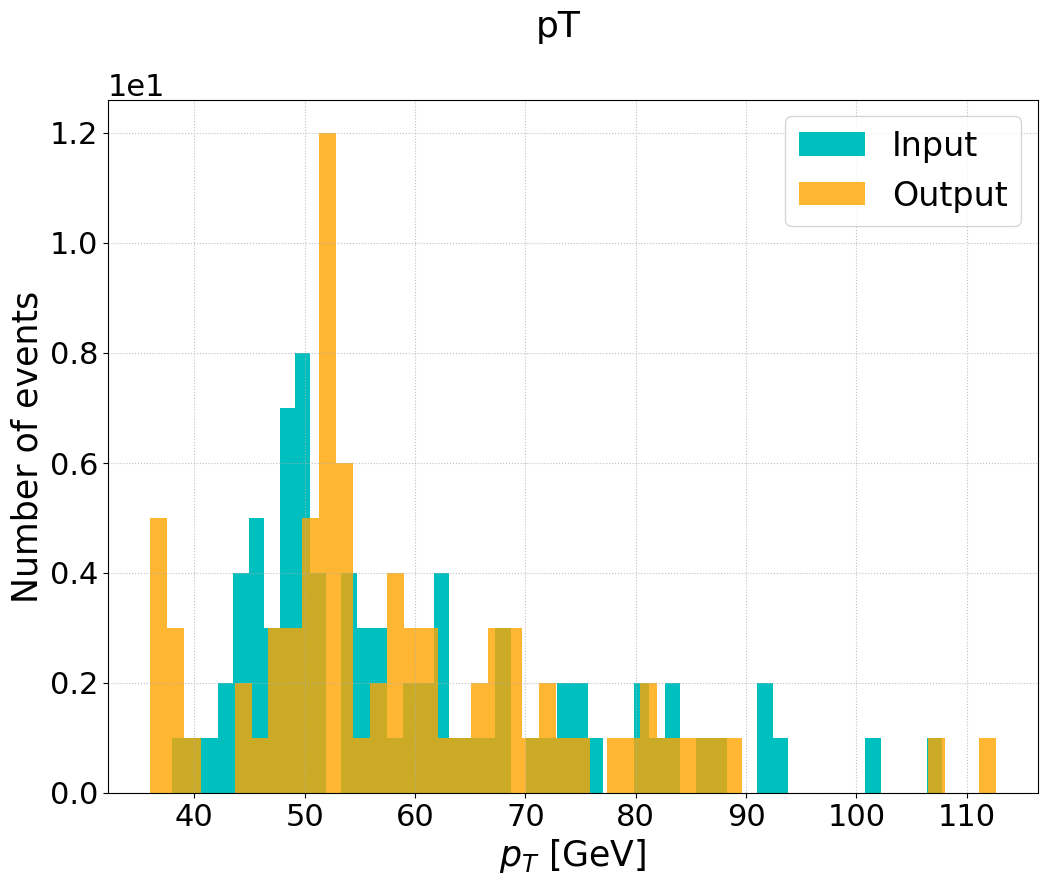

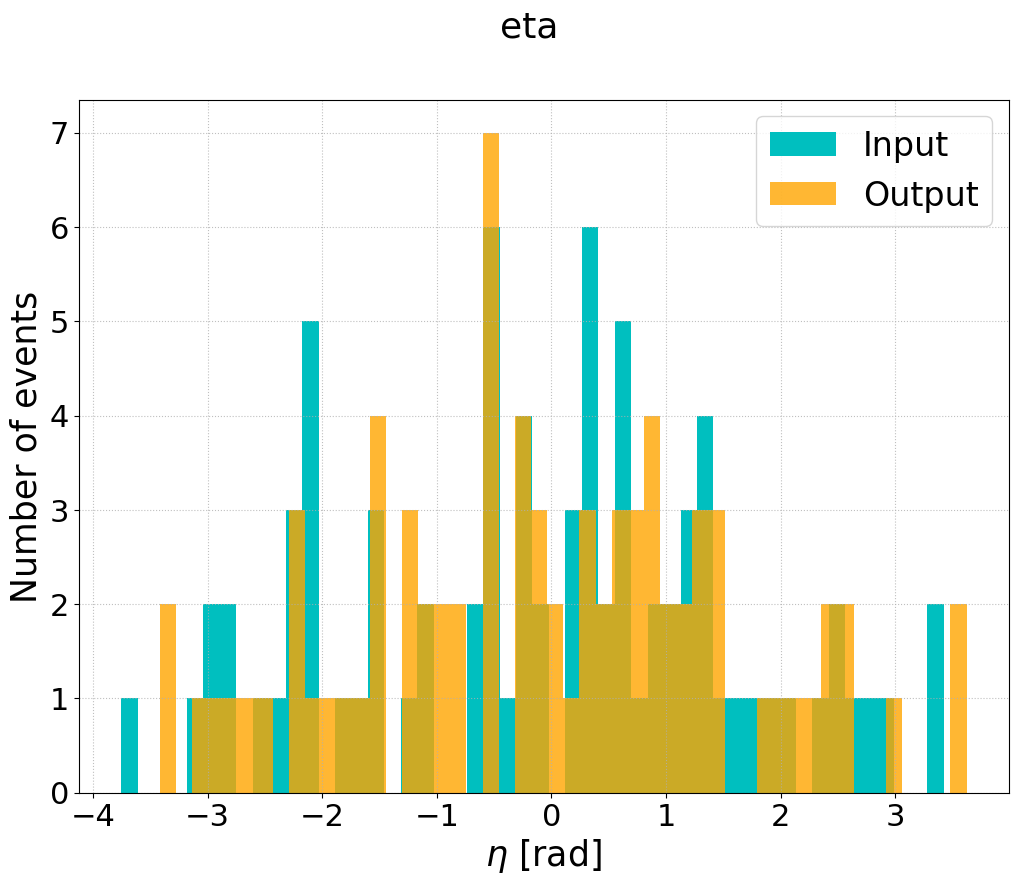

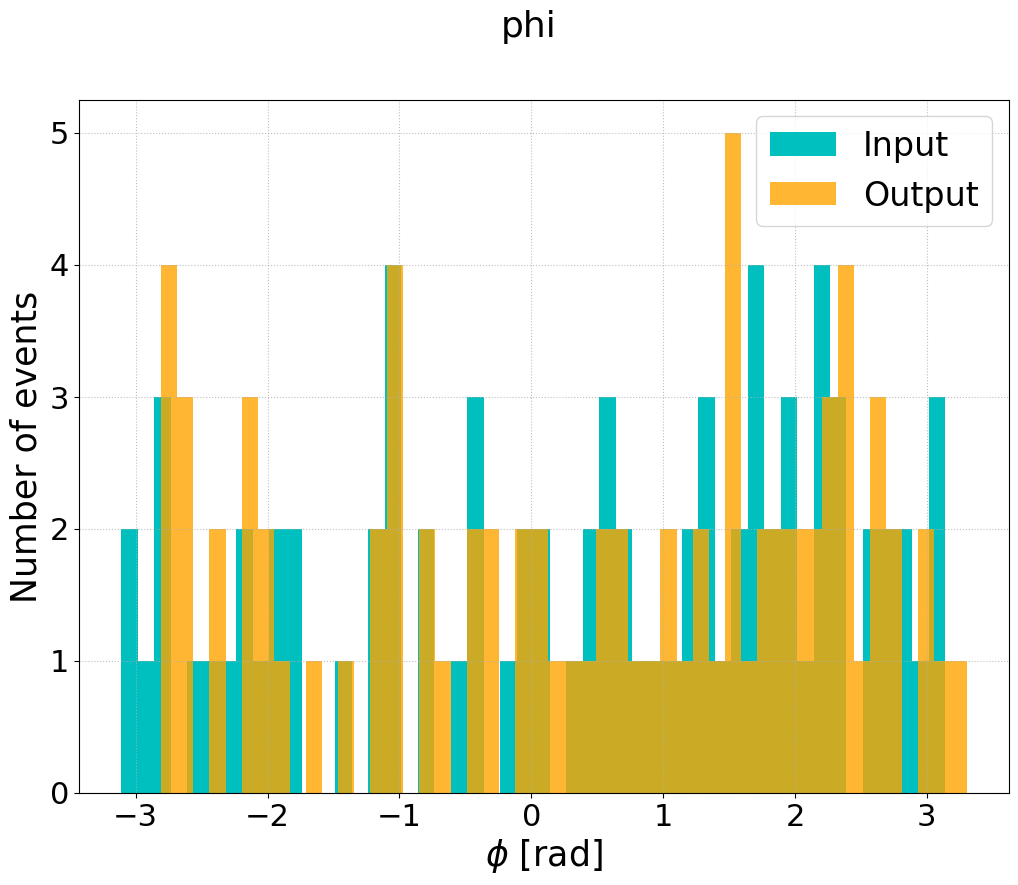

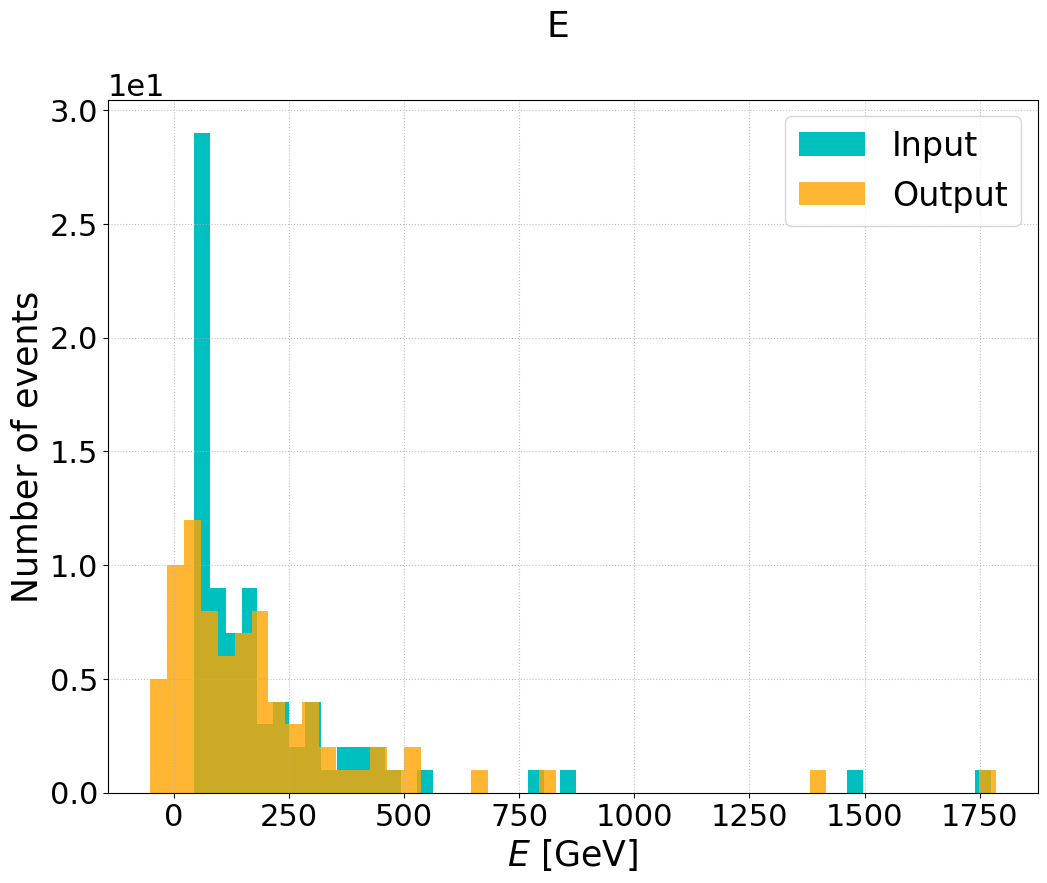

In [13]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
data = torch.tensor(train_x.values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=n_bins)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    plt.legend()

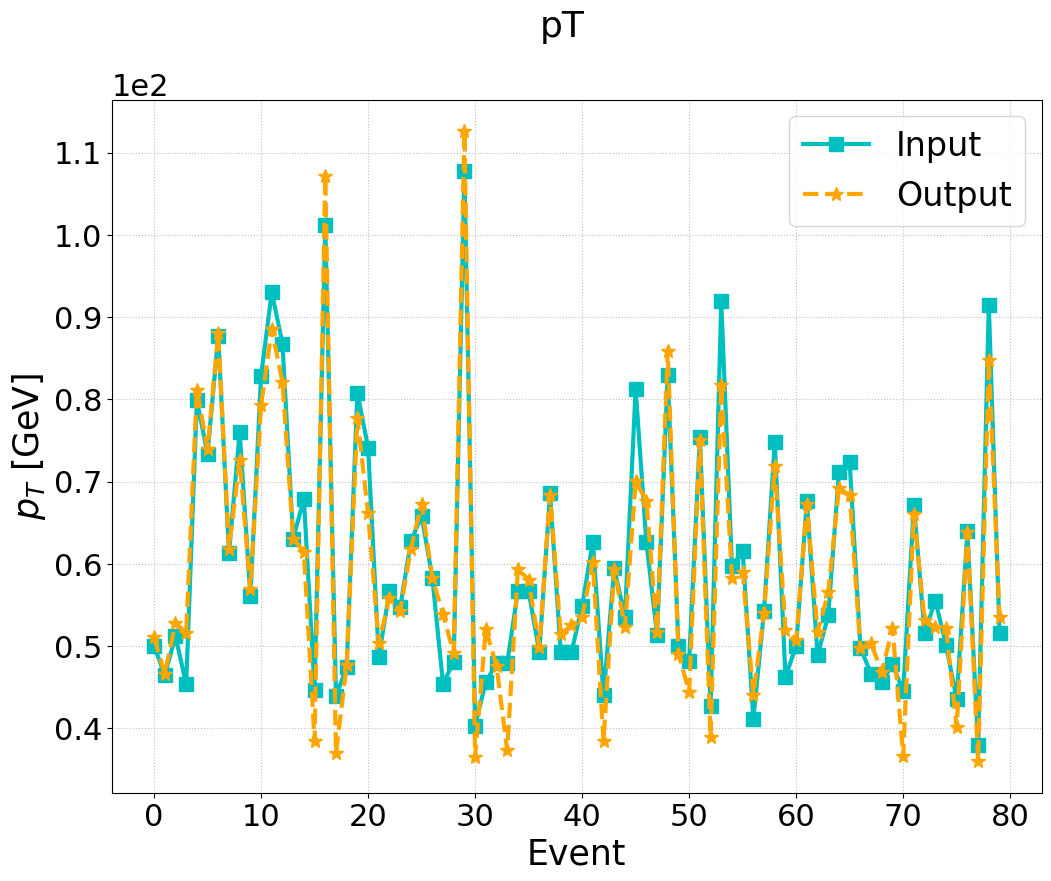

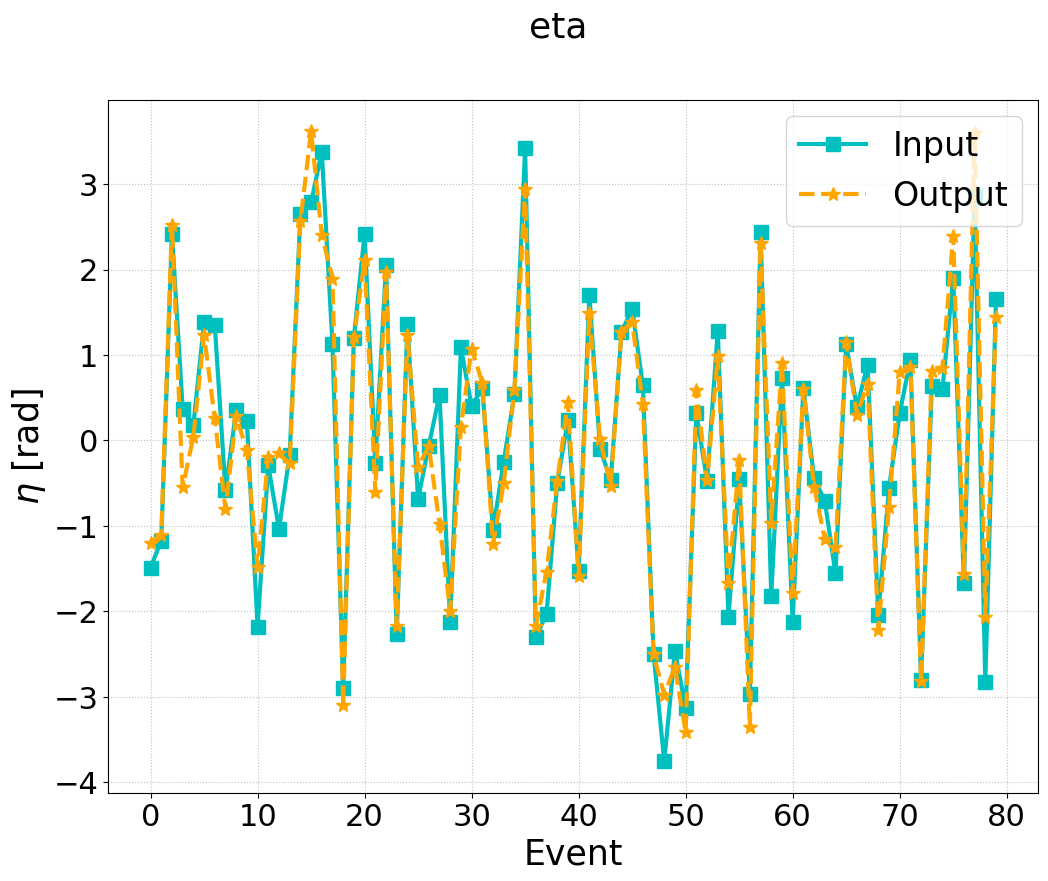

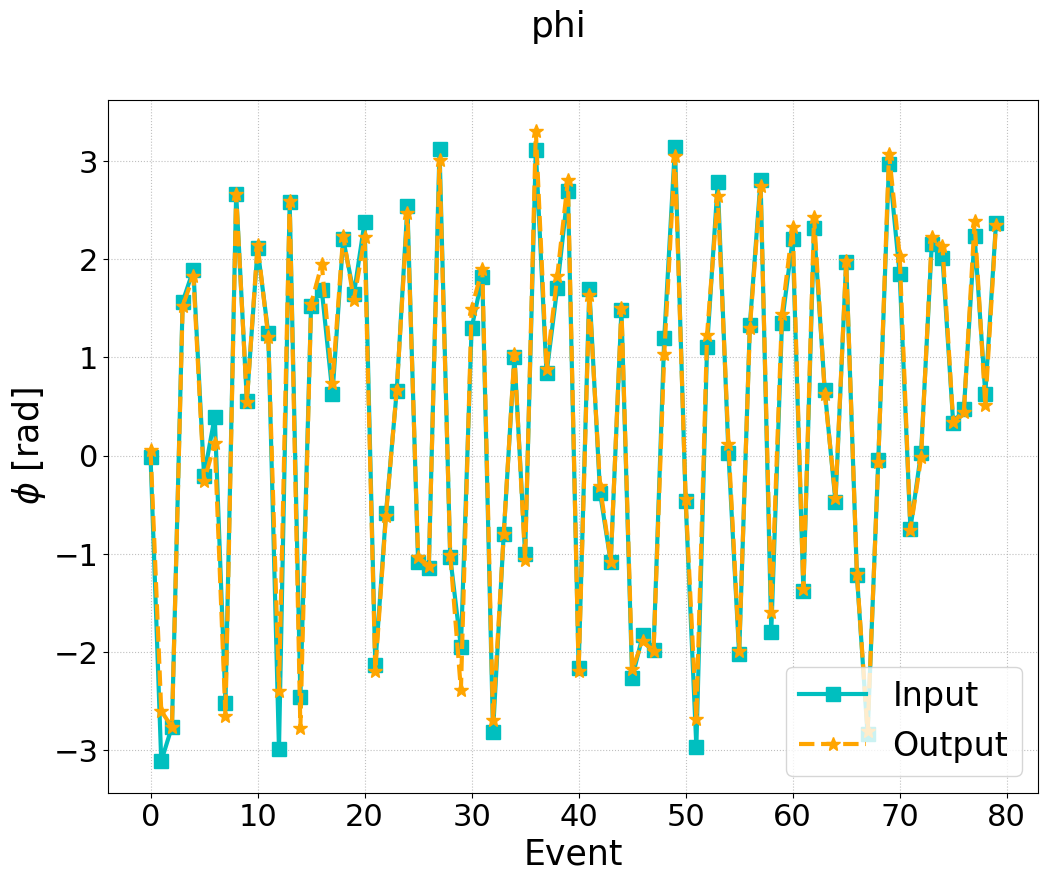

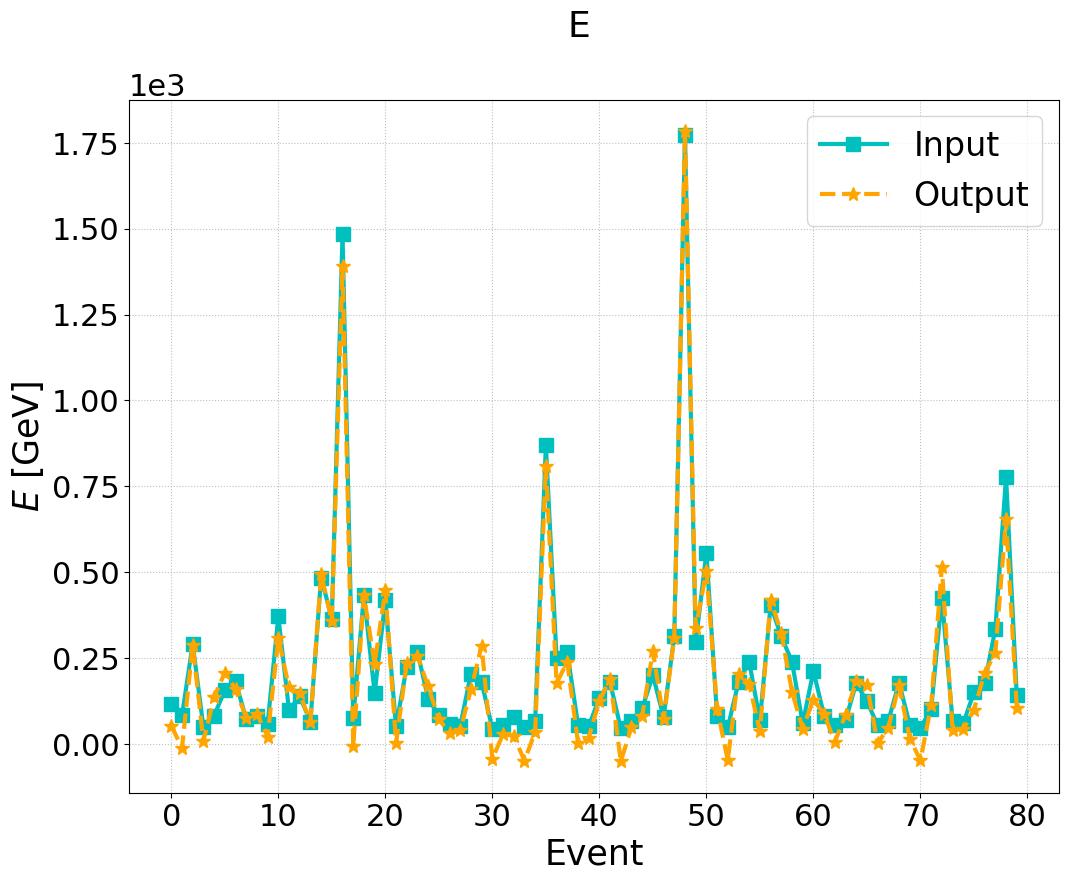

In [14]:
# Plot input on top of output
data = torch.tensor(train_x.values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()

In [15]:
# Plot input on top of output
data = torch.tensor(test_x.values)
latent = model.encode(data).detach().numpy()

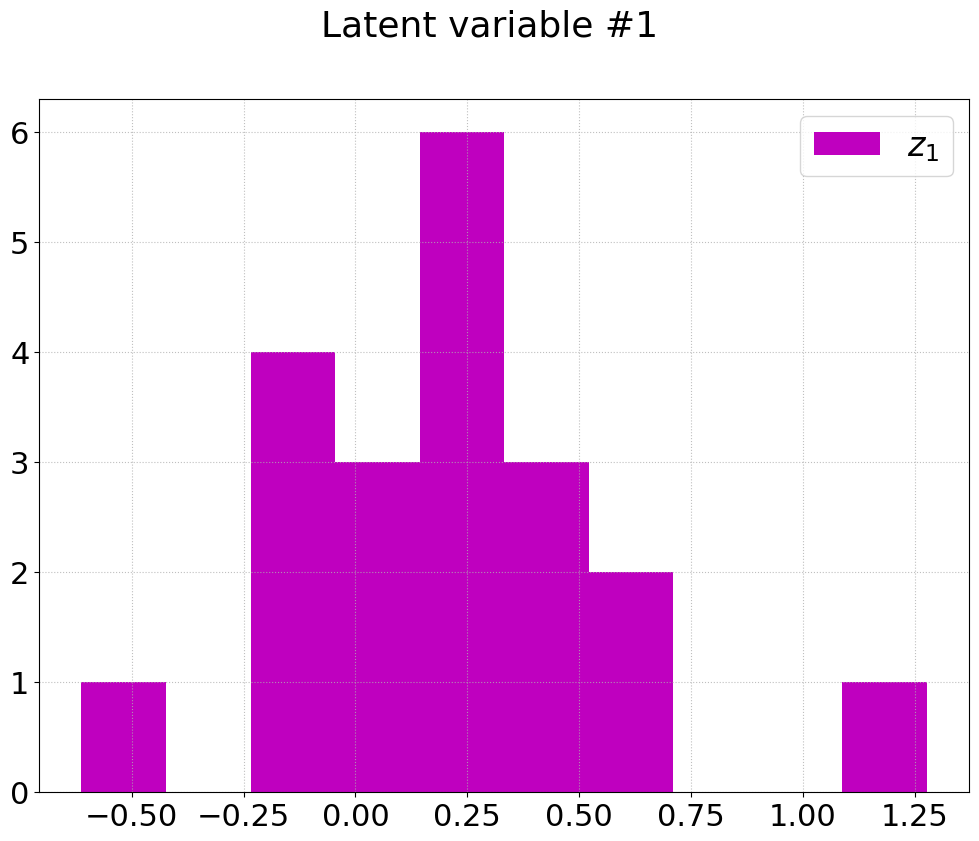

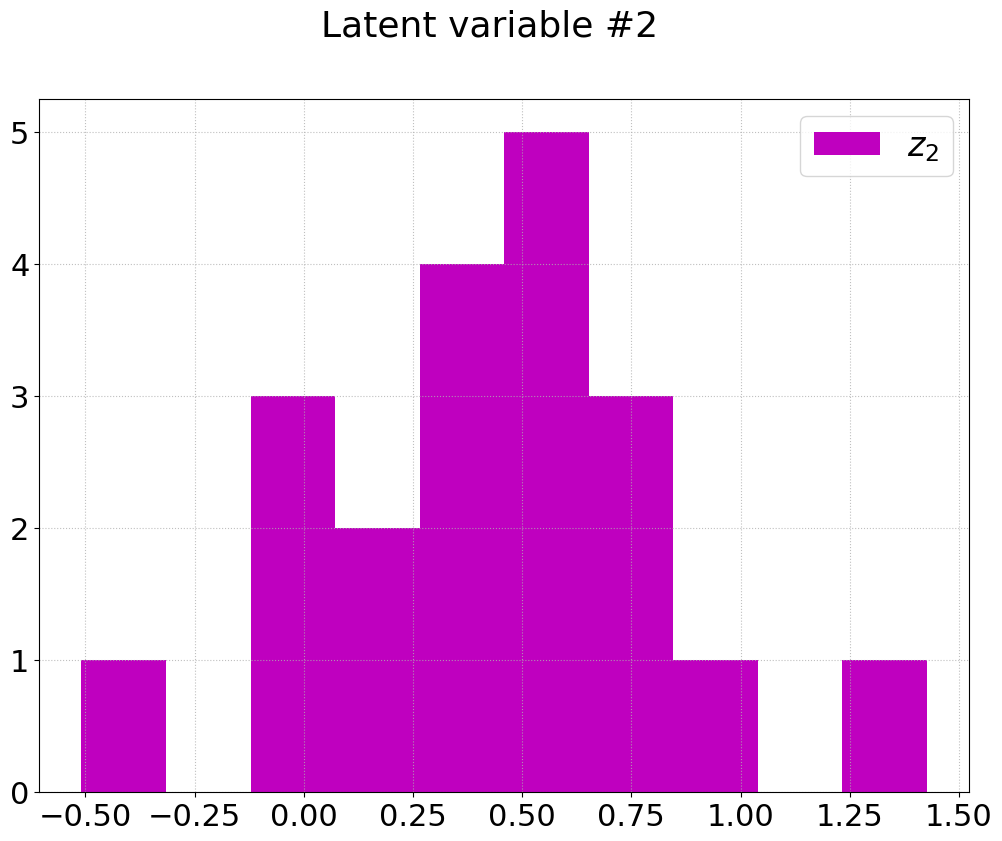

In [16]:
for ii in np.arange(latent.shape[1]):
    plt.figure()
    plt.hist(latent[:, ii], label='$z_%d$' % (ii + 1), color='m')
    plt.suptitle('Latent variable #%d' % (ii + 1))
    plt.legend()
    ms.sciy()

Text(0, 0.5, '$z_2$')

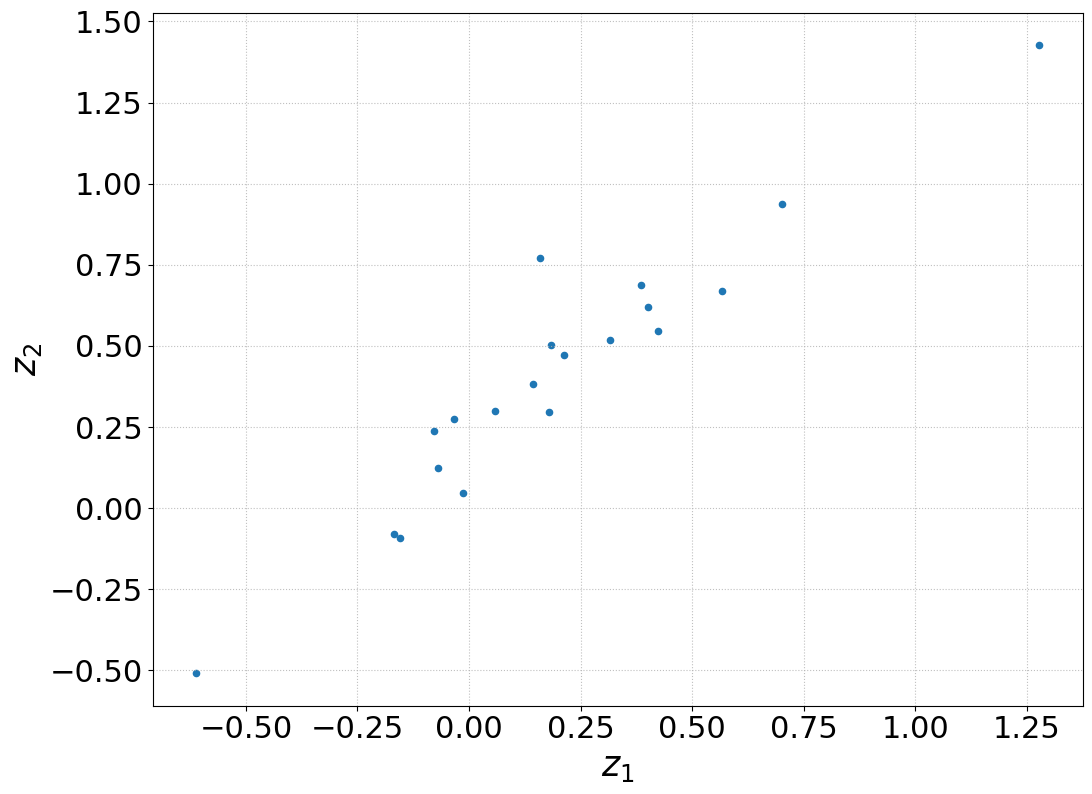

In [19]:
mksz = 20

plt.figure()
plt.scatter(latent[:, 0], latent[:, 1], s=mksz)
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')